# HW6: Autoencoder Primer

This part of the homework will consist of a gentle introduction to some of the code that will be necessary for the main notebook of HW6. This notebook will explore some utility methods and will give you some ideas about how an exploration into autoencoders can be conducted, and the following notebook will ask you to use similar techniques to implement and evaluate a variational autoencoder!

### MNIST Data

For our simple example, we are going to load in the MNIST data once again! 

**NOTES:**
- Since the dataset is so big, we will just discard the formal training set and will just use a subset of the testing set. 

- We will resize all of the images to be (32x32) just because it's an easy power of 2 (you'll see why in a second). This can still work with non-powers-of-2, but you have to do some annoying resizing, reshaping, parameter tuning, or other stuff. This just makes life easier. 
    - Of note, the next part on VAEs will not expect this. 

- We won't really be using the labels in the optimization pipeline, so we don't need to one-hot encode them.

In [41]:
import tensorflow as tf

def input_prep_fn(x):
    out = tf.expand_dims(x / 255, -1)
    out = tf.image.resize(
        out,
        [32,32],
    )
    return out

(X0, L0), (X1, L1) = tf.keras.datasets.mnist.load_data()

X0 = input_prep_fn(X0)
X1 = input_prep_fn(X1)

We will be demonstrating some plotting utilities in matplotlib, which may be useful for the main of the assignment (the notebook after this one). 

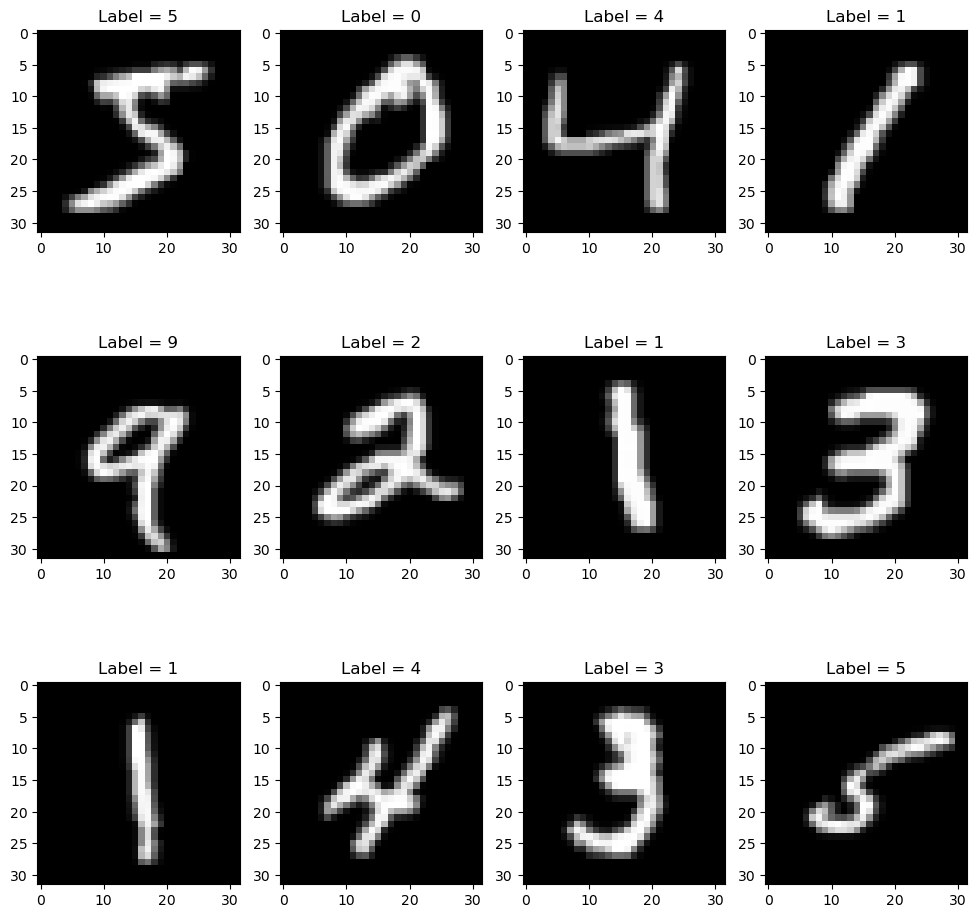

In [42]:
from matplotlib import pyplot as plt
import numpy as np

def example_plotter(x, l, nrows=3, ncols=4, figsize=(12, 12)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1: axs = np.array([axs])
    axs[0][0].set_title(f'Some Examples')
    for row in range(nrows):
        for col in range(ncols):
            i = row * ncols + col
            out_numpy = np.squeeze(x[i].numpy(), -1)
            axs[row][col].imshow(out_numpy, cmap='gray')
            axs[row][col].set_title(f'Label = {l[i]}')

example_plotter(X0, L0)

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.

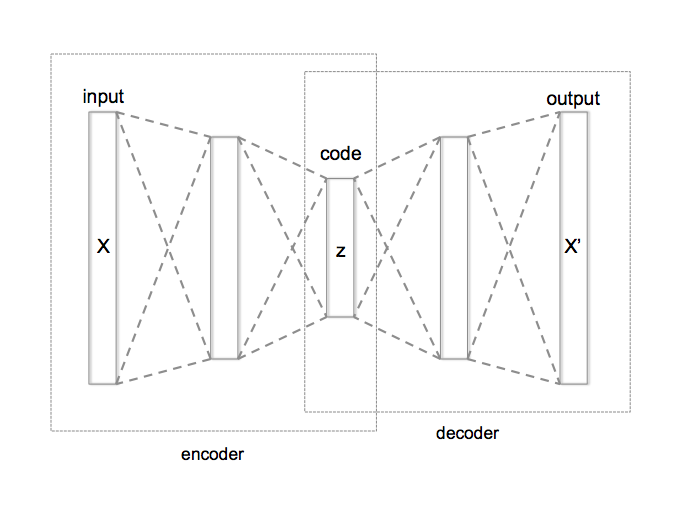

As we can see, the autoencoder is divided roughly in two parts: 
- The **encoder** that encodes the input to a "code" (internal representation) with reduced dimensions.
- The **decoder** that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function $h(x) \approx x$, or to approximate the identity function to output $h(x) = x'$ that is similar to $x$. 

This may sound like a pretty trivial task, so why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. 

E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### Implementing The Auto-Encoder

Below, we are going to ask for you to go ahead and implement an autoencoder to reconstruct MNIST digits through a bottleneck.

The basic structure of an auto-encoder has already been discussed previously and shouldn't come as a surprise: 

> Learn a hypothesis function $h(x) = h_{decoder}(h_{encoder}(x))$ such that $h(x) \sim x$.

Below, go ahead and finish the autoencoder implementation. 

- Implement the autoencoder `call()` function.

- Implement the encoder end decoder architectures with a nice bottleneck. 

- As an exercise, only Conv2D and Conv2D-Transpose layers. This is a simplified example that still allows you to leverage 2D locality without reshaping hastle. 

- Make sure that your bottleneck layer only has a single channel representation so that we can visualize it all with a single channel of info. 

**NOTES:**
- Consider what is reasonable for the encoder/decoder layers. We're going from a 32x32 one-channel input to a latent encoding and then back, so maybe extreme values in the 100s might not be useful channel specifications. 

- Note that your input and output dimensions must match. To make this easy, the MNIST digits are already powers of 2, so... do with that info what you will (something something strides)!  

- Some of the arguments are already given to you in the `conv_kwargs` dictionary, so consider using them to make your code shorter. 
   - Recall that `f(**{'n' : 2})` and `f(n=2)` are equivalent...

- Later on, you'll be seeing the first channel of the encoding layer (upsampled to a 32x32 space). So depending on what your embedding ends up, you might not see much. That's totally fine, though!

In [49]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        ## TODO: Implement call function to associate model components
        print(inputs.shape)
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

## TODO: Make encoder and decoder sub-models and construct autoencoder.
conv_kwargs = { ## Feel free to use this... or not...
    "padding"             : "SAME", 
    "activation"          : tf.keras.layers.LeakyReLU(alpha=0.2), 
}

ae_model = Autoencoder(
    encoder = tf.keras.Sequential([
        ## TODO: Implement encoder
#         tf.keras.layers.Input(shape=(32, 32, 1)),
        tf.keras.layers.Conv2D(16, (3, 3), activation=conv_kwargs["activation"], padding=conv_kwargs["padding"], strides=2),
        tf.keras.layers.Conv2D(8, (3, 3), activation=conv_kwargs["activation"], padding=conv_kwargs["padding"], strides=2)
    ], name='ae_encoder'),
    decoder = tf.keras.Sequential([
        ## TODO: Implement decoder
        tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation=conv_kwargs["activation"], padding=conv_kwargs["padding"]),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation=conv_kwargs["activation"], padding=conv_kwargs["padding"]),
        tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ], name='ae_decoder')
, name='autoencoder')

The following code shows a summary of the two models. Make sure that the architecture and parameter count make sense. Remember that this is just MNIST (ours had around 4K parameters total, though yours can be whatever you want within reason)...

In [50]:
ae_model.build(input_shape = X0.shape)   ## Required to see architecture summary
initial_weights = ae_model.get_weights() ## Just so we can reset out autoencoder

ae_model.summary()
ae_model.encoder.summary()
ae_model.decoder.summary()

(60000, 32, 32, 1)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_encoder (Sequential)     (60000, 8, 8, 8)          1320      
                                                                 
 ae_decoder (Sequential)     (60000, 32, 32, 1)        1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________
Model: "ae_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (60000, 16, 16, 16)       160       
                                                                 
 conv2d_27 (Conv2D)          (60000, 8, 8, 8)          1160      
                                                                 
Total params: 

### Making A Visualization Routine

We'd like to go ahead and see how the training is going, right? You may recall that we did something similar when we did input optimization, and the solution was to modify the `train_step` routine directly. This isn't necessarily the best way though, so let's talk about **callbacks**.

In general terms, a callback function is a function that executes throughout a pipeline or routine. You may be familiar with the keystroke callback in a general event loop, where you specify what keys you want to check for (i.e. the 'q' key to quit your program) and then the loop will execute your routine (i.e. quit the program) when it checks for user input. 

Keras also has this, and we can make our own callbacks pretty easy. The below code uses some visualization code to construct a gif image and accumulates frames on each epoch's end by overriding the `on_epoch_end` method. For more information on this, feel free to check out the [Keras custom callback documantation](https://www.tensorflow.org/guide/keras/custom_callback).

This may also be useful later, so feel free to adapt this in the regular assignment portion.

In [51]:
import matplotlib.pyplot as plt
from PIL import Image   ## Python Image Library. Will be useful for us
import io

class ImageVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, model, sample_inputs, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.sample_inputs = sample_inputs
        self.imgs = [] 

    def on_epoch_end(self, epoch, logs=None):
        encoding   = self.model.encoder(self.sample_inputs)
        prediction = self.model.decoder(encoding)  ## = self.model(self.sample_inputs)
        enc_pic = tf.image.resize(encoding, [32, 32], method=tf.image.ResizeMethod.AREA)

        self.add_to_imgs(
            tf.concat([
                self.sample_inputs,
                enc_pic[:,:,:,:1],
                prediction
            ], axis=0),
            epoch = epoch
        )

    def add_to_imgs(self, outputs, epoch, nrows=3, ncols=8, figsize=(18, 8)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image 
        to the 'imgs' list. Used to later generate a gif. 
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axs[0][0].set_title(f'Epoch {epoch+1}')
        axs[0][3].set_title('Inputs')
        axs[1][3].set_title('Encoding')
        axs[2][3].set_title('Decoding')
        for i, ax in enumerate(axs.reshape(-1)):
            out_numpy = np.squeeze(outputs[i].numpy(), -1)
            ax.imshow(out_numpy, cmap='gray')
        self.imgs += [self.fig2img(fig)]
        plt.close(fig)

    @staticmethod
    def fig2img(fig):
        """
        Convert a Matplotlib figure to a PIL Image and return it
        https://stackoverflow.com/a/61754995/5003309
        """
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        return Image.open(buf)
    
    def save_gif(self, filename='mnist_recon', loop=0, duration=500):
        imgs = self.imgs
        self.imgs[0].save(
            filename+'.gif', save_all=True, append_images=self.imgs[1:], 
            loop=loop, duration=duration)
        
## NOTE: It may be useful for you to move this cell block above the model 
##  construction area to where you can easily switch between modifying 
##  your model and running it. Whatever works best...

### Actually Training The Model!

Finally, it's time to actually train the model! Hurray!

To optimize our architecture, we could use mean squared error like before, right? OR maybe we could use binary cross-entropy. There might actually be merit to both though...

Why don't you try implementing a combination of both!

**NOTES:**
 - There are many ways of implementing a custom loss function, which include: 
   - Implementing a [custom loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss) from scratch.

     - You can create a true keras loss function or just a simple custom one will also work. 

   - Taking several loss functions and combining them by redirecting the loss arguments into both of them.
     - If you do that, consider using `def mse_bce_loss(*args, **kwargs)` to capture all of the positional and keyword arguments.

 - You will have to balance the loss functions with a scaling term. Consider the evaluation metrics and think about what would be a good equalizing scaler. 

 - You may have to tune the learning rate!

In [55]:
## Callback function: Visualized the last 8 images in dataset (which are never trained on)
imgviz_callback = ImageVisualizer(ae_model, X0[-8:])  

ae_model.set_weights(initial_weights)  ## Resets model weights. 

mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

## TODO: Construct a weighted mse/bce loss function of choice. 
def mse_bce_loss(*args, **kwargs):
    return 20*mse_loss(*args, **kwargs) + bce_loss(*args, **kwargs)

ae_model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss        = mse_bce_loss,
    metrics     = [
        tf.keras.metrics.MeanSquaredError(), 
        tf.keras.metrics.BinaryCrossentropy()
    ]
)

ae_model.fit(
    X0[:5000], X0[:5000],
    epochs     = 10,
    batch_size = 20,
    validation_data = (X0[5000:6000], X0[5000:6000]),
    callbacks  = [imgviz_callback]
);

Epoch 1/10
(20, 32, 32, 1)
(20, 32, 32, 1)
250/250 [==============================] - 4s 12ms/step - loss: 0.9661 - mean_squared_error: 0.0377 - binary_crossentropy: 0.2121 - val_loss: 0.2036 - val_mean_squared_error: 0.0045 - val_binary_crossentropy: 0.1141
Epoch 2/10
250/250 [==============================] - 3s 12ms/step - loss: 0.1755 - mean_squared_error: 0.0034 - binary_crossentropy: 0.1084 - val_loss: 0.1556 - val_mean_squared_error: 0.0025 - val_binary_crossentropy: 0.1063
Epoch 3/10
250/250 [==============================] - 3s 11ms/step - loss: 0.1479 - mean_squared_error: 0.0022 - binary_crossentropy: 0.1042 - val_loss: 0.1411 - val_mean_squared_error: 0.0018 - val_binary_crossentropy: 0.1042
Epoch 4/10
250/250 [==============================] - 3s 14ms/step - loss: 0.1375 - mean_squared_error: 0.0017 - binary_crossentropy: 0.1026 - val_loss: 0.1344 - val_mean_squared_error: 0.0016 - val_binary_crossentropy: 0.1031
Epoch 5/10
250/250 [==============================] - 3s 11m

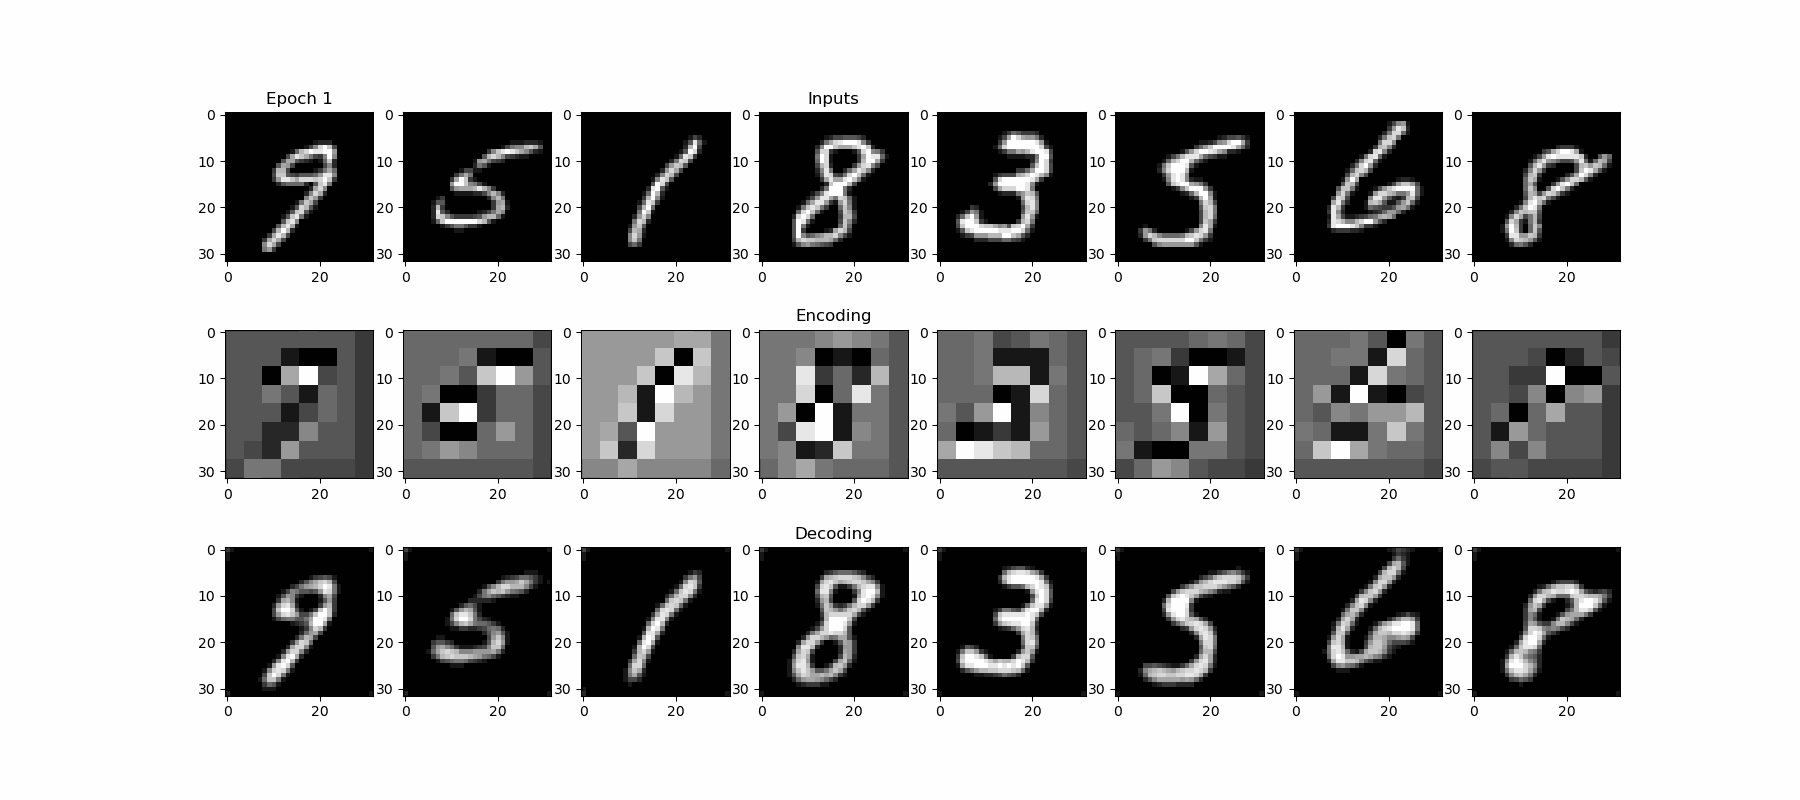

In [54]:
import IPython.display  ## For displaying images/gifs generated in your notebook

imgviz_callback.save_gif('reconstructions')
IPython.display.Image(open('reconstructions.gif','rb').read())

## **[FOR CREDIT]**
- Confirm that the digits are able to be reconstructed in the bottleneck 
    - Make sure to leave the gif inside your notebook so we can see it!
    - Make a few notes below talking about whether or not this is interesting and/or useful.
- Confirm that the latent encoding's decomposition roughly matches with original data's. 
    - Run the visualization code below and leave it in your output. 
    - Comment a bit on it. Is this a good sign? Does it have any use?

## Visualizing the Data Representation

We can now visualize where MNIST data points are positioned in the lower dimensional vector space created by the autoencoder. In the higher-dimensional space, the data can still be projected by unsupervised machine learning techniques like [TSNE, or *t-distributed stochastic neighbor embedding*](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). The following is a simple showing of the TSNE projection of a subset of the input data down to only 2 dimensions. The colors here represent different MNIST digit, so see how the letters are positioned relative to each other. 

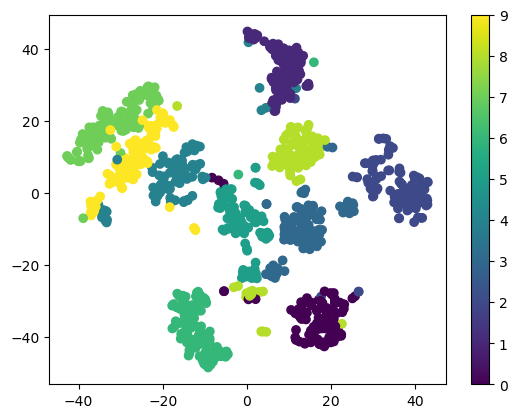

In [56]:
from sklearn.manifold import TSNE

def project_down(x, l):
    num_samples = len(x)
    z = np.reshape(x, [num_samples, -1])
    tsne = TSNE(n_components=2, learning_rate='auto', init='random')
    transformed = tsne.fit_transform(z)
    colors = l
    plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
    plt.colorbar()
    plt.show()

num_samples = 1000
project_down(X0[-num_samples:], L0[-num_samples:])

If we do the same with the encoding of the autoencoder model, we'll notice that the same relevant information about the digits is preserved even though the dimensionality of this space is much lower than the original. Note that this experiment is very useful if you're trying to show that a technique still holds valuable relationships about a dataset. 

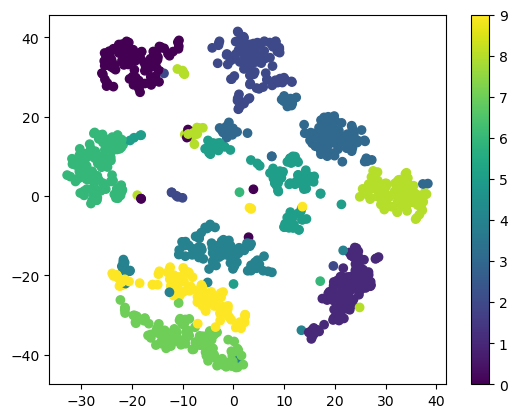

In [57]:
from sklearn.manifold import TSNE

num_samples = 1000
project_down(ae_model.encoder(X0[-num_samples:]), L0[-num_samples:])

As we can see, the autoencoder has succeeded in its task of encoding a high-dimensional dataset down to a very low-dimensional one just by optimizing through a bottleneck! 